# HYPERPARAMETER SEARCH

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
import os
sys.path.append(os.path.abspath('..'))

from src.data import load_data, download_data, compute_features
from src.lstm import LSTMRegressor, train_lstm, evaluate_lstm
from utils.tscv import run_fixed_window_tscv, run_lstm_tscv

# Set seeds for reproducibility
random_state = 42
torch.manual_seed(random_state)
np.random.seed(random_state)

In [2]:
feature_cols = [
    "LogReturn",
    "RealisedVolatility",
    "RSI_14",
    "BB_Width",
    "MACD",
    "YZVolatility",
    "Log_CO",
    "Log_HL",
]
ticker = "TSLA"
start_date = "2015-01-01"
seq_len = 30

## TSCV - Time Series Cross Validation

In [12]:
# Load the FULL raw dataframe
df_full = download_data(ticker, start_date=start_date)
df_full = compute_features(df_full)

# Define X and y (Raw, unscaled)
X_raw = df_full[feature_cols].values
y_raw = df_full["RealisedVolatility"].values
dates_raw = df_full.index.values

[*********************100%***********************]  1 of 1 completed


### 4.1 Random Forest Regressor

In [13]:
train_size = 22*12*3   # ~3 years
test_size = 22*12
n_folds = (len(X_raw) - train_size - seq_len) // test_size
print(n_folds)

7


In [14]:
# Best Hyperparameters found with Fixed Window TSCV
n_estimators = 300  # [100, 200, 300, 400, 500]
seq_len = 30  # [10, 30, 60, 120, 252]
# 30: 0.0555, 0.0902
# 252: 0.0508, 0.0711

rf_mae_tscv, rf_rmse_tscv = run_fixed_window_tscv(
    model_class=RandomForestRegressor,
    model_params={
        'n_estimators': n_estimators,
        'random_state': random_state,
        'n_jobs': -1
    },
    X=X_raw,
    y=y_raw,
    dates=dates_raw,
    seq_len=seq_len,
    train_size=22*12*3,
    test_size=22*12,
    verbose=False
)

--- Starting FIXED-WINDOW TSCV for RandomForestRegressor ---

Average MAE: 0.0557
Average RMSE: 0.0905


In [ ]:
#  --------------- DO NOT RUN THIS (+1H TIME) ---------------

# from utils.param_search import hyperparameter_search_rf

# best_params, best_seq_len, best_score = hyperparameter_search_rf(
#     X=X_raw,
#     y=y_raw,
#     dates=dates_raw,
#     seq_lens=[30, 60, 120, 252],
#     param_grid={
#         "n_estimators": [200, 300, 500],
#         "max_depth": [None, 10, 20],
#         "min_samples_leaf": [1, 3, 5],
#         "min_samples_split": [2, 5],
#     },
#     train_size=22 * 12 * 3,
#     test_size=22 * 12,
#     verbose=True
# )

# print("\n BEST RESULTS")
# print("Best MAE =", best_score)
# print("Best seq_len =", best_seq_len)
# print("Best parameters:", best_params)

# Runner Up Models: MAE, RMSE - seq_len, params 
# 0.0534, 0.0879 - seq_len=30, params={'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 42, 'n_jobs': -1}
# 0.0534, 0.0879 - seq_len=30, params={'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'random_state': 42, 'n_jobs': -1}
# 0.0527, 0.0877 - seq_len=30, params={'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 42, 'n_jobs': -1}
# 0.0525, 0.0876 - seq_len=30, params={'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 42, 'n_jobs': -1}

# BEST MODEL
# 0.0525, 0.0876 - seq_len=30, params={'n_estimators': 300, 'max_depth': 20,   'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 42, 'n_jobs': -1}

In [19]:
(X_train, y_train, dates_train), _, (X_test, y_test, dates_test) = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.85,
    test_size=0.15,
)

# Train RF with optimal parameters on trainintg set
optimal_params = {
    'n_estimators': 300,
    'max_depth': 20,
    'min_samples_leaf': 5,
    'min_samples_split': 2,
    'random_state': 42,
    'n_jobs': -1
}
rf_best = RandomForestRegressor(**optimal_params)
n_train, seq_length, num_features = X_train.shape
X_train_rf = X_train.reshape(n_train, seq_length * num_features)
n_test = X_test.shape[0]
X_test_rf = X_test.reshape(n_test, seq_length * num_features)

rf_best.fit(X_train_rf, y_train)
rf_best_test_preds = rf_best.predict(X_test_rf)

rf_best_test_mae = mean_absolute_error(y_test, rf_best_test_preds)
rf_best_test_rmse = np.sqrt(mean_squared_error(y_test, rf_best_test_preds))

print(f"Random Forest Regressor with Optimal Hyperparameters on Test Set:")
print(f"\tTest MAE:  {rf_best_test_mae:.6f}")
print(f"\tTest RMSE: {rf_best_test_rmse:.6f}")

[*********************100%***********************]  1 of 1 completed


Random Forest Regressor with Optimal Hyperparameters on Test Set:
	Test MAE:  0.117128
	Test RMSE: 0.222624


In [20]:
print(X_test_rf.shape)

(405, 240)


### 4.2 LSTM

In [3]:
from src.lstm import LSTMDataset

(X_train, y_train, dates_train), (X_val, y_val, dates_val), (X_test, y_test, dates_test) = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.7,
    test_size=0.15,
)

batch_size = 32
train_ds = LSTMDataset(X_train, y_train)
val_ds   = LSTMDataset(X_val,   y_val) if X_val is not None else None
test_ds  = LSTMDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False) if val_ds else None
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


In [4]:
from src.lstm import LSTMRegressor

lstm_model = LSTMRegressor(
    input_size=len(feature_cols),
    hidden_size=32,
    num_layers=1,
    dropout=0.3
    )

model_name = f"{ticker}_best_lstm_model.pth"
metrics = train_lstm(
    lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    lr=1e-3,
    model_name=model_name
)
train_loss_history, train_rmse_history, val_loss_history, val_rmse_history, val_mase_history = metrics

lstm_model.load_state_dict(torch.load(f"../models/{model_name}"))
lstm_preds, lstm_test_mae, lstm_test_rmse = evaluate_lstm(lstm_model, test_loader, y_test)

print(f"LSTM Regressor Test MAE:  {lstm_test_mae:.6f}")
print(f"LSTM Regressor Test RMSE: {lstm_test_rmse:.6f}")

/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/100 | Train RMSE: 0.173638 | Val RMSE: 0.182314
Epoch 20/100 | Train RMSE: 0.160212 | Val RMSE: 0.156574
Epoch 30/100 | Train RMSE: 0.153413 | Val RMSE: 0.152788
Epoch 40/100 | Train RMSE: 0.146977 | Val RMSE: 0.155048
Early stopping at epoch 44. Best Val RMSE: 0.150949, at epoch 29.

Training finished. Best model saved to ../models/TSLA_best_lstm_model.pth 
Best Val RMSE: 0.150949 at epoch 29

LSTM Regressor Test MAE:  0.137536
LSTM Regressor Test RMSE: 0.217959


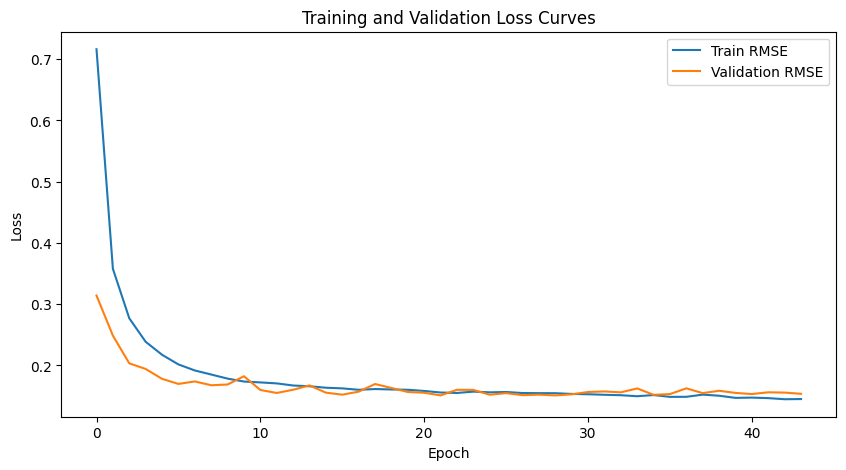

In [5]:
# Plot train and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

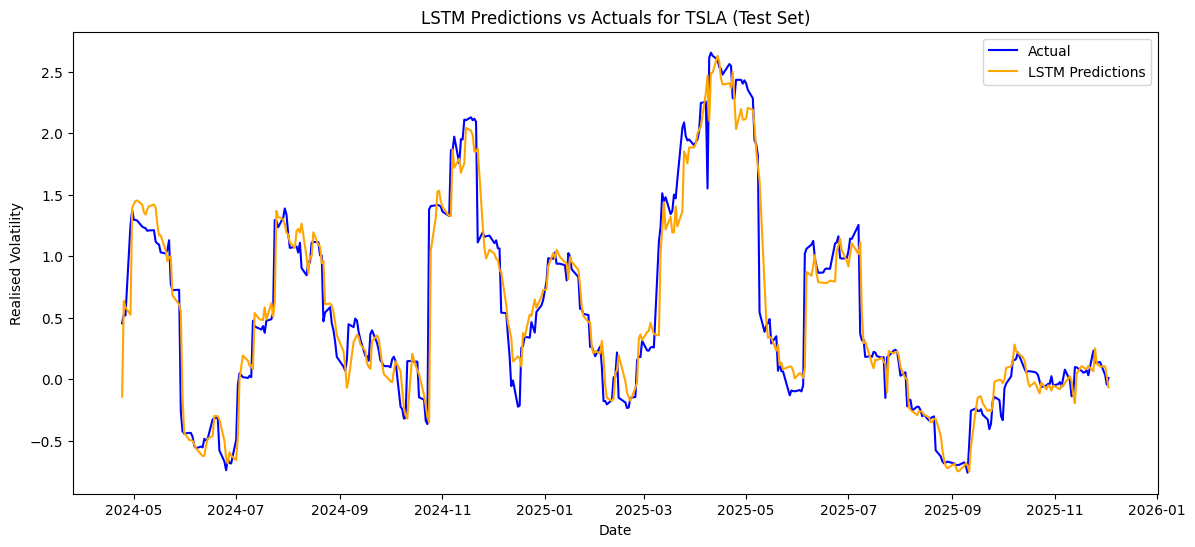

In [6]:
# Plot LSTM predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, lstm_preds, label='LSTM Predictions', color='orange')
plt.title(f'LSTM Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

In [ ]:
# Best hyperparameters found
hidden_size = 64  # [32, 64, 128]
num_layers = 1  # [1, 2]
seq_len = 30  # [10, 30, 60, 120, 252]

print(f"\nLSTM TSCV Results - Hidden Size: {hidden_size}, Num Layers: {num_layers}, seq_len: {seq_len}")
lstm_mae_tscv, lstm_rmse_tscv = run_lstm_tscv(
    X=X_raw,
    y=y_raw,
    dates=dates_raw,
    seq_len=seq_len,
    n_splits=5,
    gap=30,
    lstm_params={
        "input_size": len(feature_cols),
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "dropout": 0.3,
    },
    verbose=False
)

# BEST MODEL
# Hidden Size: 64, Num Layers: 1


LSTM TSCV Results - Hidden Size: 64, Num Layers: 1, seq_len: 30
--- Starting LSTM TSCV with 5 splits ---


/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 | Train RMSE: 0.032164 | Val RMSE: 0.038869
Epoch 20/50 | Train RMSE: 0.026675 | Val RMSE: 0.036267
Epoch 30/50 | Train RMSE: 0.025236 | Val RMSE: 0.035565
Epoch 40/50 | Train RMSE: 0.023955 | Val RMSE: 0.037445
Early stopping at epoch 49. Best Val RMSE: 0.035450

Training finished. Best model saved to ../models/lstm_tscv_fold0.pth 
Best Val RMSE: 0.035450



/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 | Train RMSE: 0.026024 | Val RMSE: 0.034594
Epoch 20/50 | Train RMSE: 0.026138 | Val RMSE: 0.034894
Epoch 30/50 | Train RMSE: 0.025734 | Val RMSE: 0.031109
Epoch 40/50 | Train RMSE: 0.022808 | Val RMSE: 0.031026
Early stopping at epoch 42. Best Val RMSE: 0.029149

Training finished. Best model saved to ../models/lstm_tscv_fold1.pth 
Best Val RMSE: 0.029149



/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 | Train RMSE: 0.034973 | Val RMSE: 0.110395
Epoch 20/50 | Train RMSE: 0.031956 | Val RMSE: 0.090069
Epoch 30/50 | Train RMSE: 0.030413 | Val RMSE: 0.079302
Early stopping at epoch 32. Best Val RMSE: 0.071246

Training finished. Best model saved to ../models/lstm_tscv_fold2.pth 
Best Val RMSE: 0.071246



/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 | Train RMSE: 0.044470 | Val RMSE: 0.050387
Epoch 20/50 | Train RMSE: 0.039831 | Val RMSE: 0.047627
Early stopping at epoch 25. Best Val RMSE: 0.046341

Training finished. Best model saved to ../models/lstm_tscv_fold3.pth 
Best Val RMSE: 0.046341



/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 | Train RMSE: 0.042260 | Val RMSE: 0.035631
Epoch 20/50 | Train RMSE: 0.039580 | Val RMSE: 0.036494
Early stopping at epoch 22. Best Val RMSE: 0.034186

Training finished. Best model saved to ../models/lstm_tscv_fold4.pth 
Best Val RMSE: 0.034186


=== LSTM TSCV Summary ===
Average MAE:  0.0696
Average RMSE: 0.1061
